# Homework 6

In [60]:
import numpy as np
import cv2 
import skimage.exposure
import skimage.io
import matplotlib.pyplot as plt
import glob

# Задача №1 - Выделить береговую линию

Теперь приступим к задаче сегментации на картинках. Реализуйте программу, которая определить береговую линию, то есть разделит изображение на 2 класса: берег и вода. Разметка лежит в папке ships/ground_truth

Примеры изображений:
<table><tr>
    <td> <img src="ships/img/0d5b831d8.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="ships/ground_truth/0d5b831d8.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

C:\Users\Arina\AppData\Local\Temp\ipykernel_24060\474543258.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 100), constrained_layout=True)


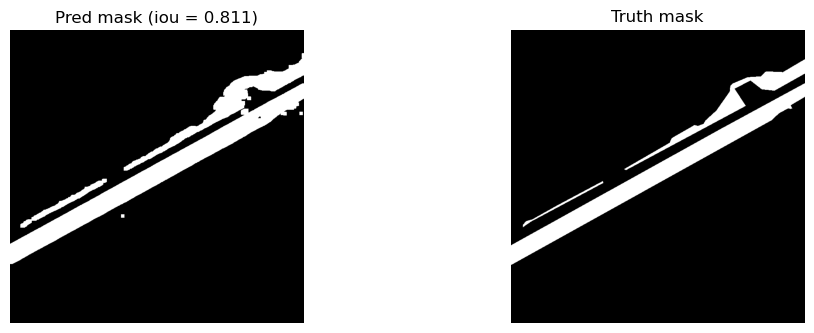

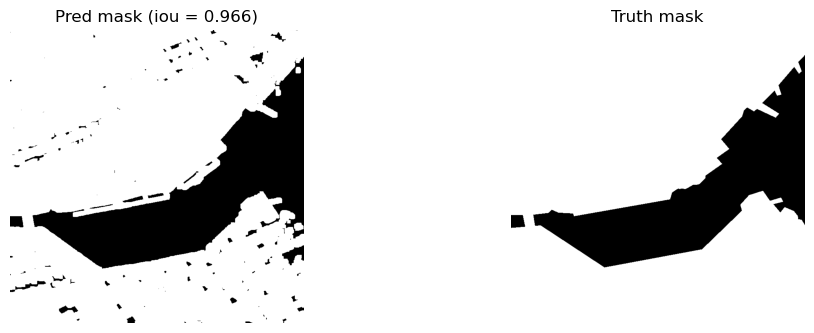

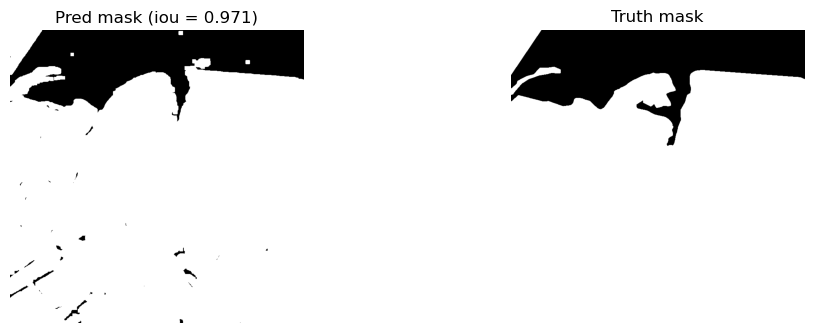

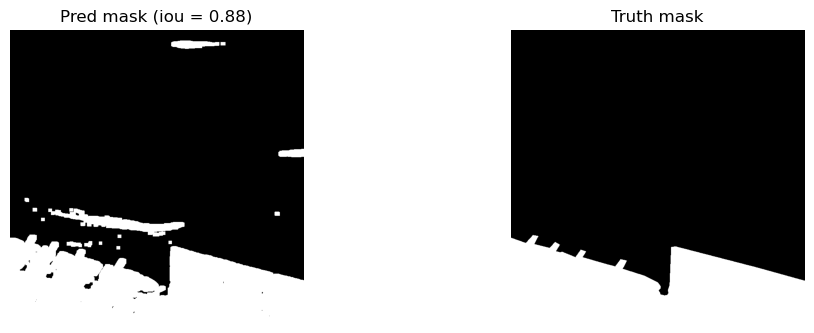

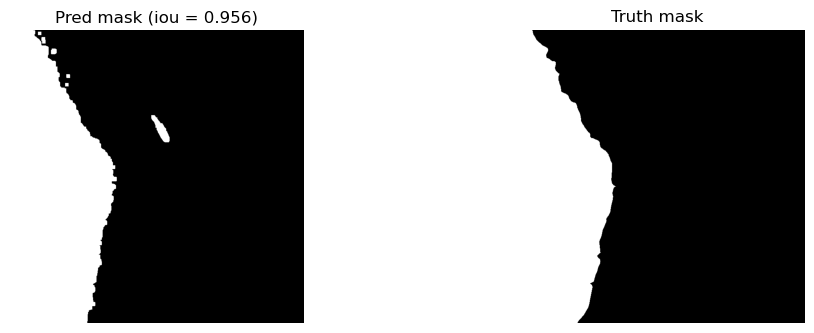

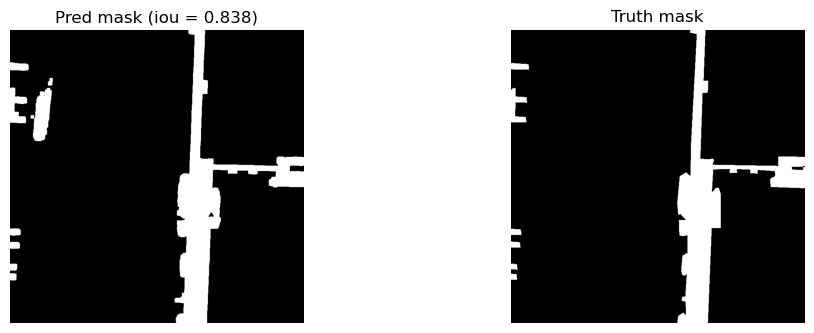

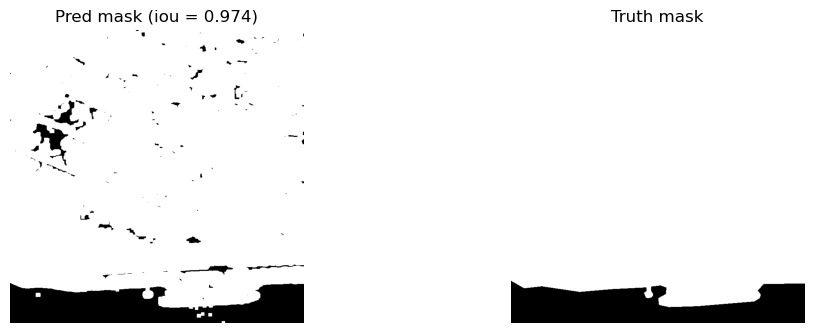

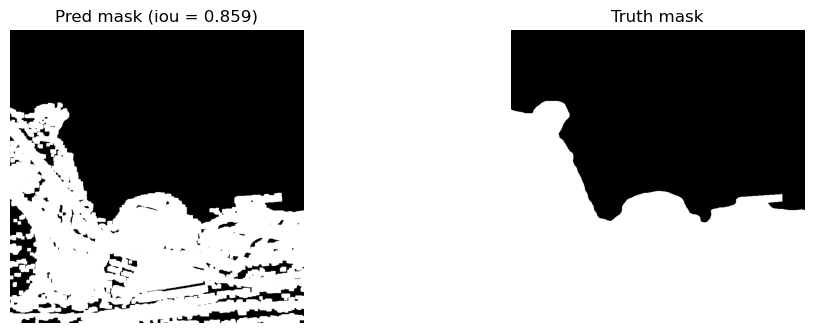

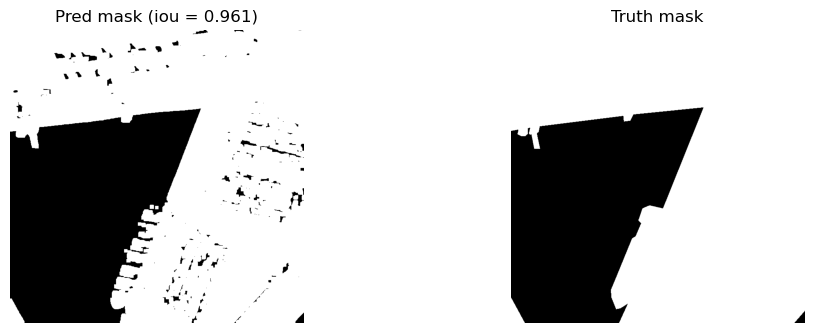

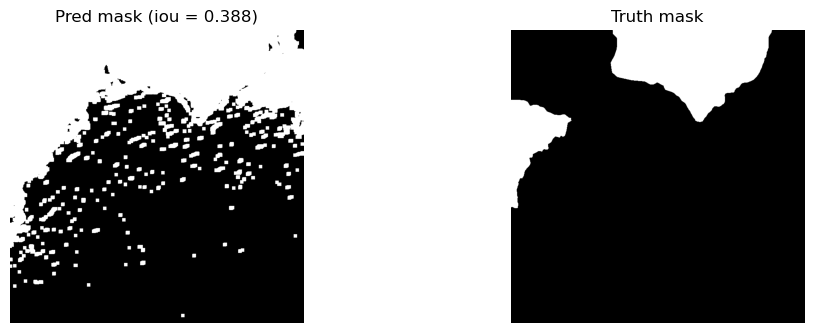

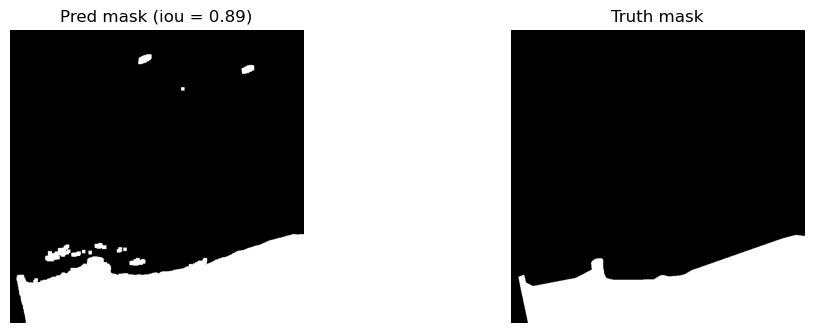

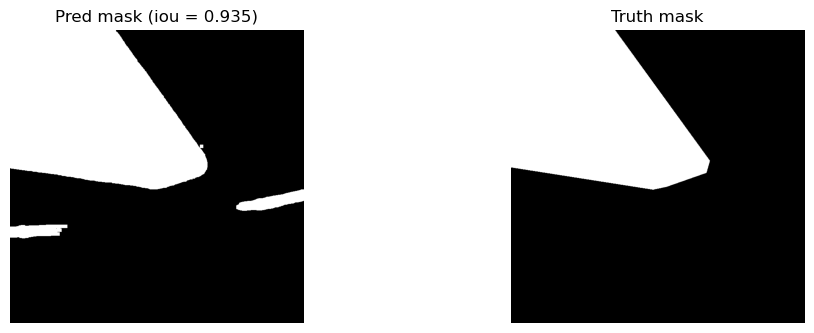

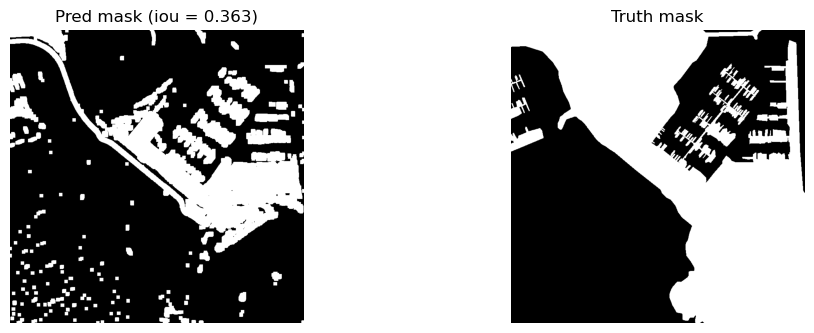

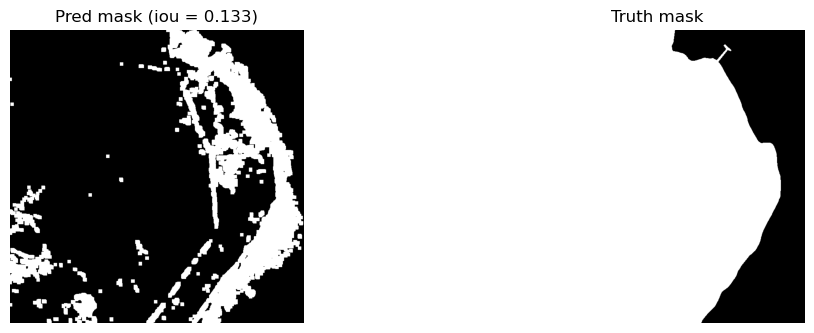

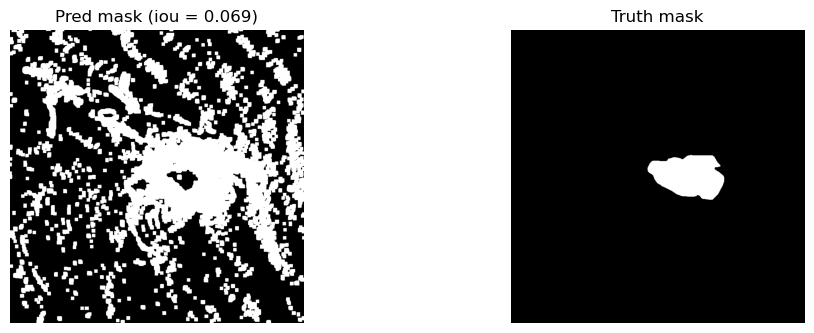

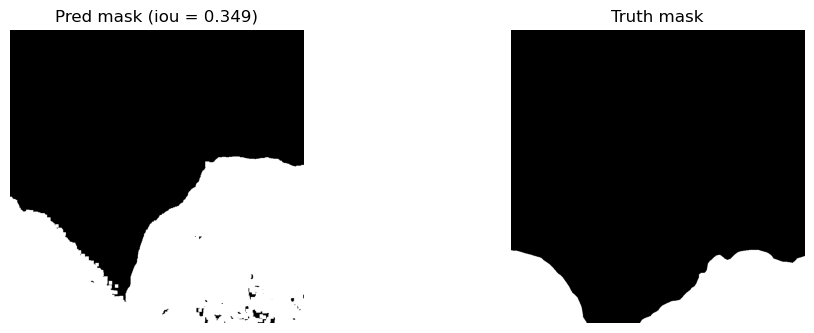

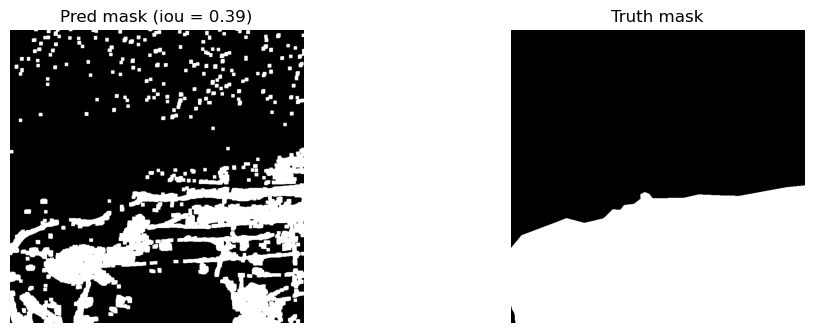

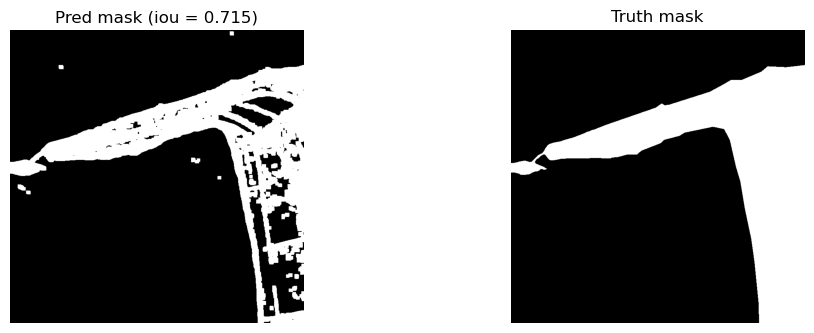

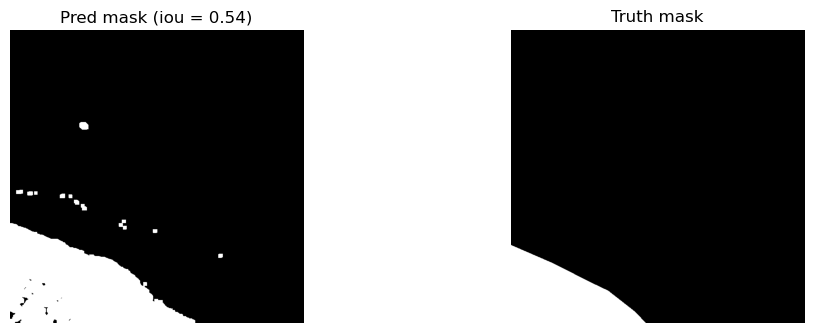

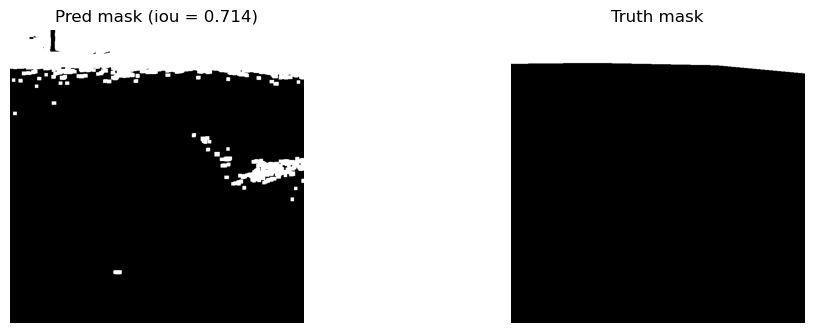

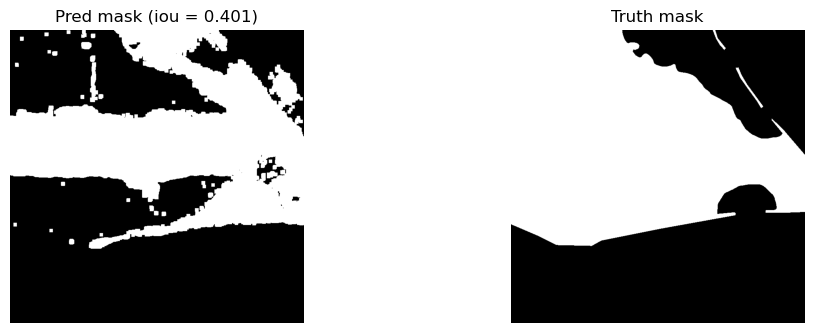

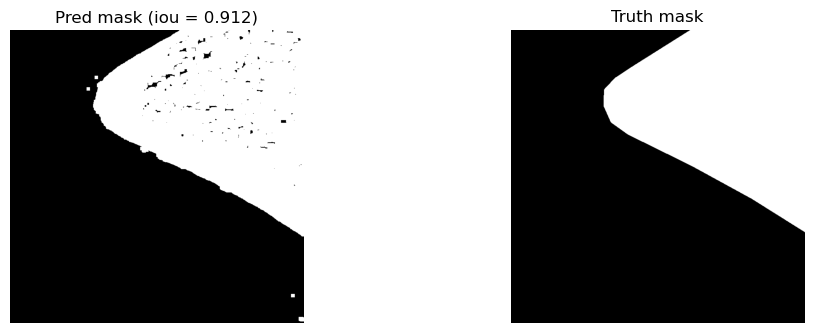

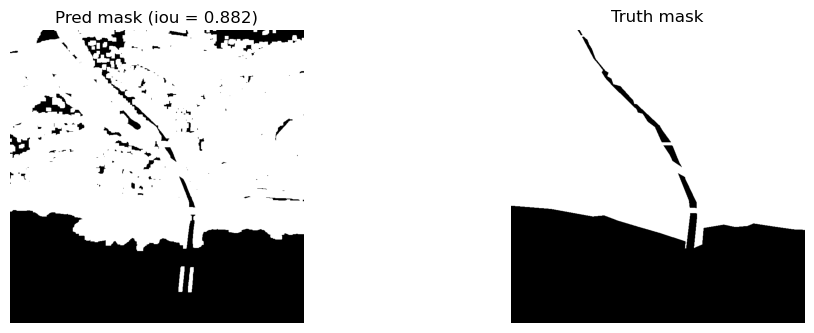

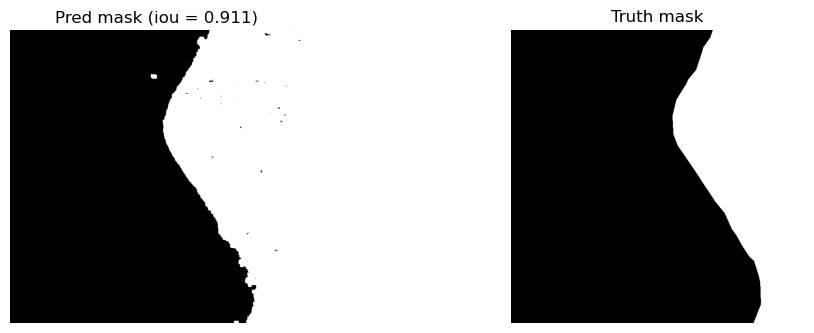

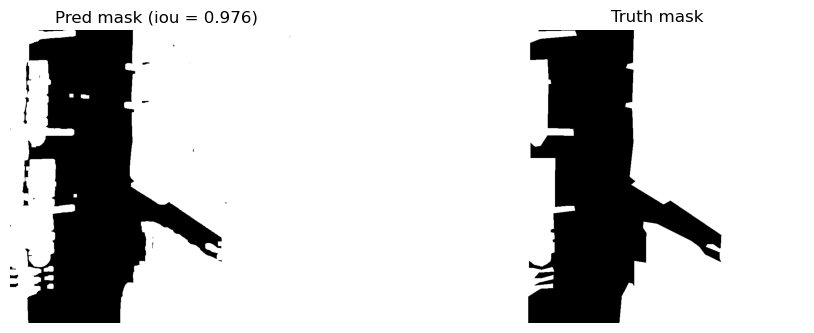

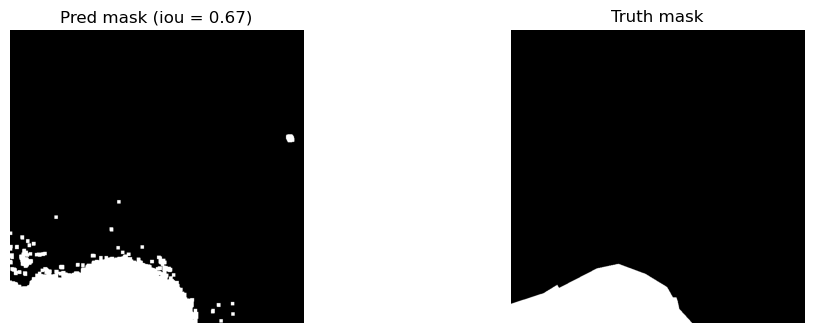

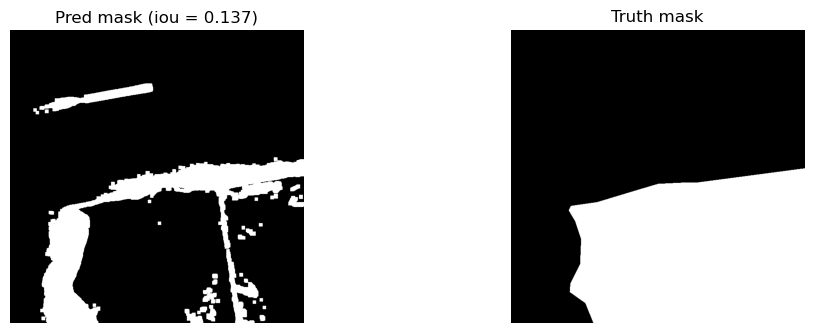

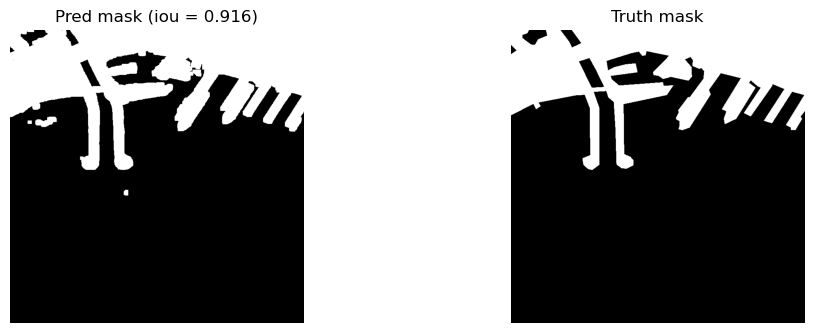

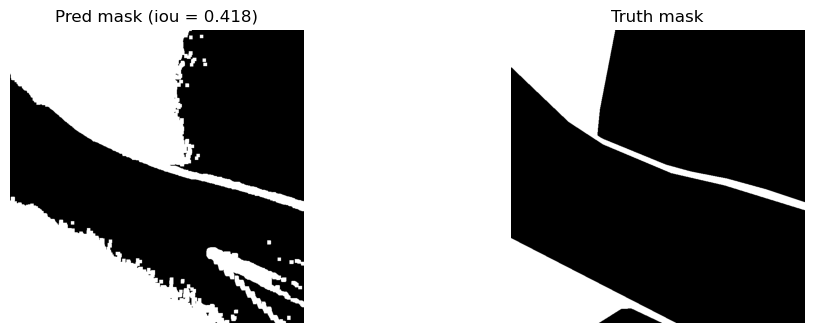

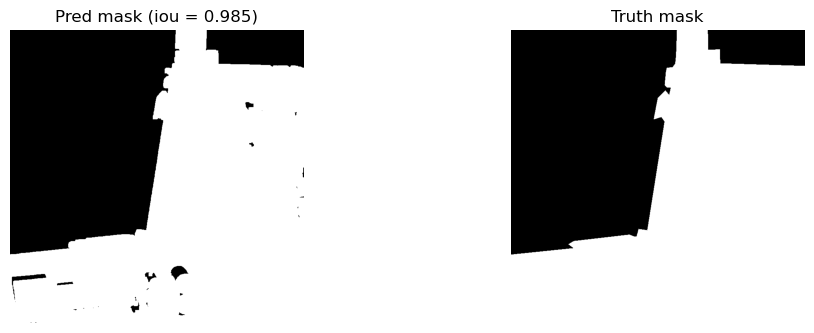

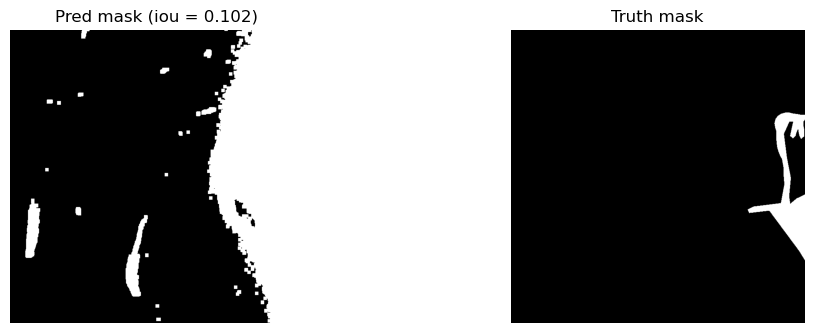

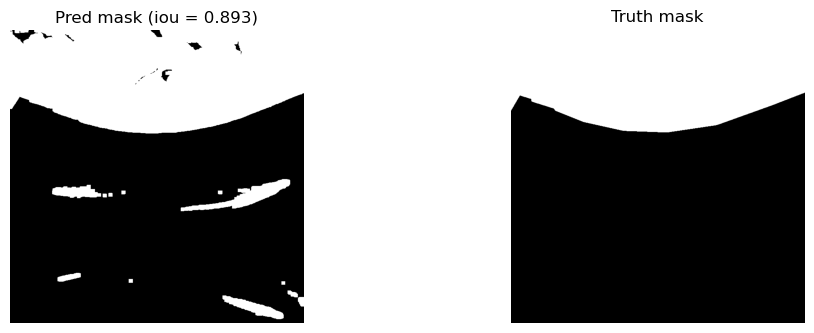

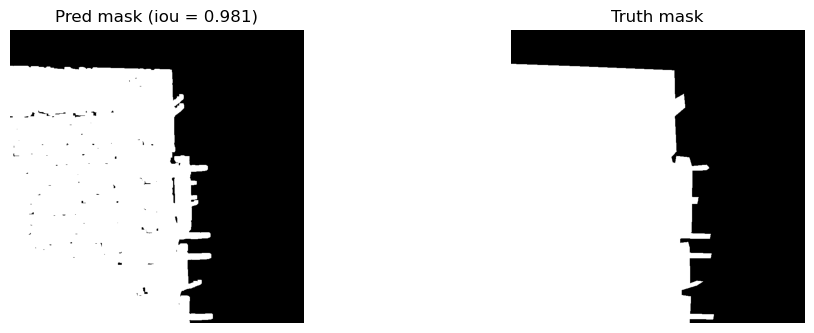

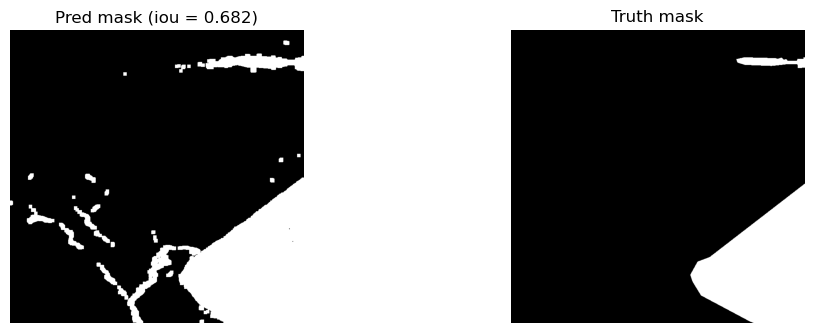

In [524]:
images = glob.glob('ships/img/*.jpg')
masks = glob.glob('ships/ground_truth/*.png')
n = len(images)
count = 1
for i in range(n):
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
    
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    hist = cv2.calcHist([blur.ravel()], [0], None, [256], [0, 256])
    extr = np.argmax(hist[:101])
    crop = np.invert(blur<(extr+20)).astype(np.uint8)
    
    kernel = np.ones((3, 3))
    opening = cv2.morphologyEx(crop, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    mask = cv2.dilate(closing, kernel, iterations=3)
    
    real_mask = cv2.imread(masks[i])
    real_mask = cv2.cvtColor(real_mask.copy(), cv2.COLOR_BGR2RGB)
    gray_mask = cv2.cvtColor(real_mask.copy(), cv2.COLOR_RGB2GRAY)
    
    gt_mask = (gray_mask > 0)
    
    intersection = mask * gt_mask
    union = (mask + gt_mask)>0
    iou = intersection.sum() / union.sum()
    
    plt.figure(figsize=(10, 100), constrained_layout=True)
    
    plt.subplot(n, 2, count)
    plt.title(f"Pred mask (iou = {iou.round(3)})")
    plt.axis('off')
    plt.imshow(mask, cmap='gray')
    
    count += 1
    
    plt.subplot(n, 2, count)
    plt.title("Truth mask")
    plt.axis('off')
    plt.imshow(gt_mask, cmap='gray')
    
    count += 1

# Задача №2 - Отделить три класса (треугольник, круг, квадрат) друг от друга

Реализуйте программу, которая делит изображение на три класса : треугольник, круг, квадрат. Сложность состоит в том, что сегментацию нужно выполнить и на зашумленных данных. Все картинки лежат в папке figures/img, разметка к ним - в figures/gt

Примеры изображений:
<table><tr>
    <td> <img src="figures/img/little_noise.png" alt="Drawing" style="width: 400px;"/> </td>
    <td> <img src="figures/gt/little_noise.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

In [509]:
def triangle_kernel(kerlen):
    r = np.arange(kerlen)
    kernel1d = (kerlen + 1 - np.abs(r - r[::-1])) / 2
    kernel2d = np.outer(kernel1d, kernel1d)
    kernel2d /= kernel2d.sum()
    return kernel2d

def do_contrast(image, alpha=1.0):
    image = image.astype(np.float32)
    gray  = image * np.array([[[0.114, 0.587,  0.299]]])
    gray  = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
    image = alpha*image  + gray
    image = np.clip(image, 0, 255).astype(np.uint8)
    return image

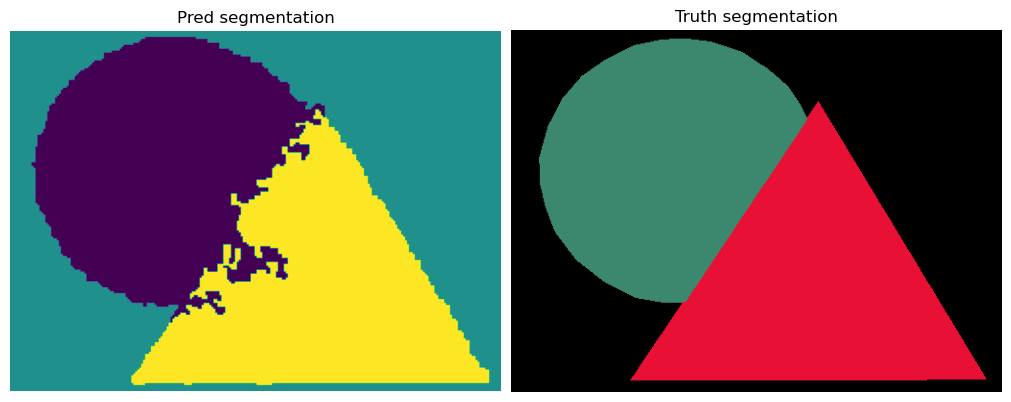

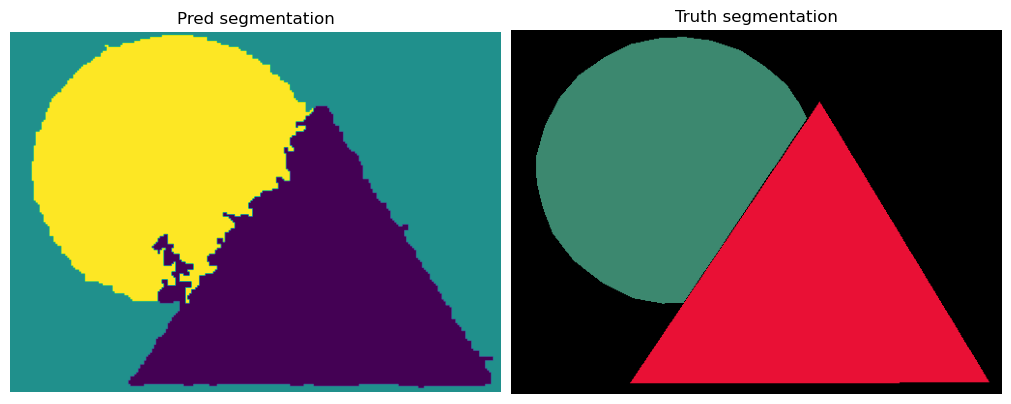

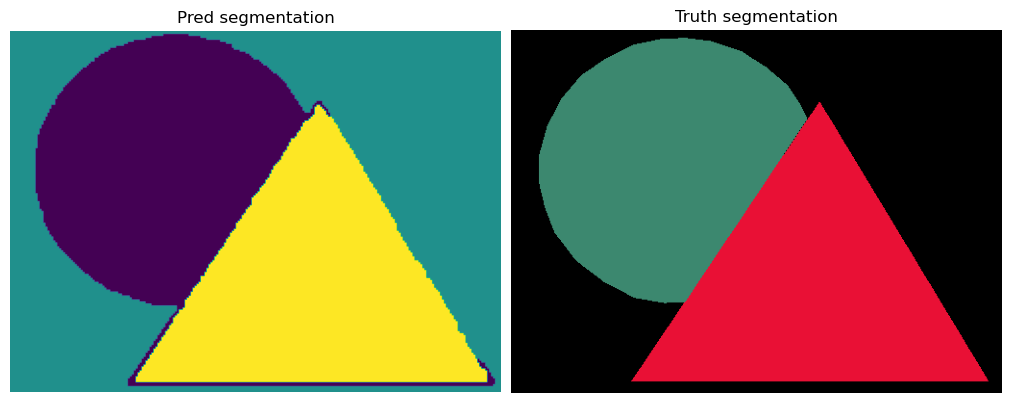

In [521]:
images = glob.glob('figures/img/*.png')
masks = glob.glob('figures/gt/*.png')
n = len(images)
count = 1
for i in range(n):
    img = cv2.imread(images[i])
    x, y, _ = img.shape
    img_crop = img[5:x-5, 5:y-5]
    
    blur = cv2.GaussianBlur(img_crop, (7,7), 0)
    kernel = triangle_kernel(7)
    res = cv2.filter2D(blur, -1, kernel)
    
    kernel = np.ones((3, 3))
    opening = cv2.morphologyEx(res, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    dilation = cv2.dilate(closing, kernel, iterations=3)

    contrast = do_contrast(dilation, alpha=3.0)
    
    trans_img = skimage.transform.resize(res, tuple(map(int, np.array(res.shape[:2])/2)))
    X = np.reshape(trans_img, (-1, 1))
    connectivity = grid_to_graph(*trans_img.shape)
    ward = AgglomerativeClustering(n_clusters=3, connectivity=connectivity,
                                   linkage='ward', distance_threshold=None).fit(X)
    label_aggl = np.reshape(ward.labels_, trans_img.shape)
    
    plt.figure(figsize=(10, 50), constrained_layout=True)
    
    plt.subplot(n, 2, count)
    plt.title("Pred segmentation")
    plt.axis('off')
    plt.imshow(label_aggl[...,0])
    
    count += 1
    
    gt_mask = cv2.imread(masks[i])
    plt.subplot(n, 2, count)
    plt.title("Truth segmentation")
    plt.axis('off')
    plt.imshow(gt_mask)
    
    count += 1